<a href="https://colab.research.google.com/github/olivcha/U-NET-for-medical-image-segmentation/blob/main/u-net-cw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import tarfile
import imageio
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.


In [ ]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2023-03-03 15:57:48--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2023-03-03 15:57:49--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbf26a6a12d2fba4994ad23f7f5.dl.dropboxusercontent.com/cd/0/inline/B3ic5ij1p4KBQhSjP_sWb3Fw0pLH0L6WiP8g10mrdQXCzv67emlRDSKA8hQbyZCTVzg1CsuQVzs8HsTwqjnUH9wg6KsSovc6fMG1XEzWNTaiiqlAtlZK0kUSKXaBqlKf6u6RQL_LGk4tJ8yg-htBUYRDKGlVIOzEW1QvNhmcvxYQlQ/file# [following]
--2023-03-03 15:57:49--  https://ucbf26a6a12d2fba4994ad23f7f5.dl.dropboxusercontent.com/cd/0/inline/B3ic5ij1p4KBQhSjP_sWb3Fw0pLH0L6W

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

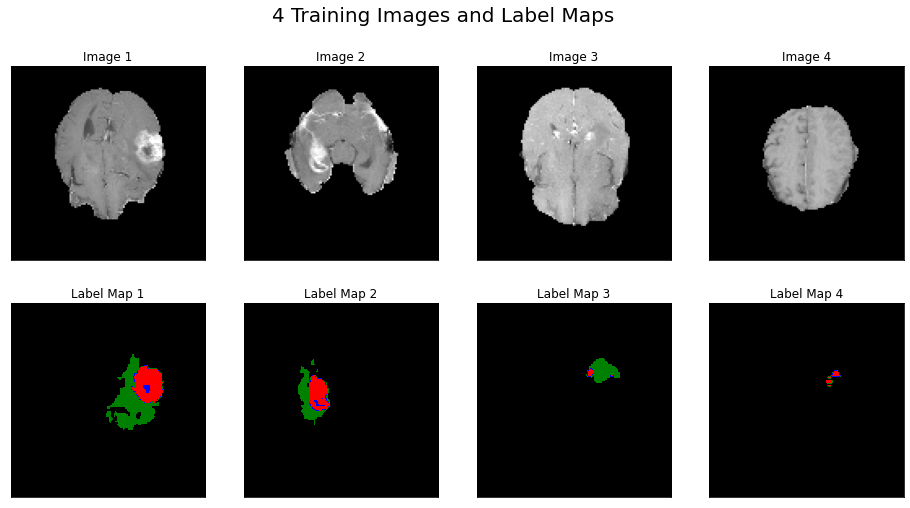

In [ ]:
# Define the color maps
cmap_gray = 'gray'
cmap_label = colors.ListedColormap(['black', 'green', 'blue', 'red'])

# Get a list of all image files in a directory
image_files = glob.glob('Task01_BrainTumour_2D/training_images/*.png')
label_files = glob.glob('Task01_BrainTumour_2D/training_labels/*.png')

# Randomly choose 4 images
chosen_files = random.sample(image_files, 4)

# Create a 2x4 subplot grid
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Loop over the chosen files and plot each image and its label map
for i, item in enumerate(chosen_files):
    # Load the image and label map
    image = imageio.imread(item)
    label_file = item.replace('training_images', 'training_labels')
    label = imageio.imread(label_file)

    # Plot the image and its label map
    axs[0, i].imshow(image, cmap=cmap_gray)
    axs[0, i].set_title(f'Image {i+1}')
    axs[1, i].imshow(label, cmap=cmap_label)
    axs[1, i].set_title(f'Label Map {i+1}')

    # Remove the ticks from the plots
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

# Add a title to the figure
fig.suptitle('4 Training Images and Label Maps', fontsize=20)

# Show the plot
plt.show()

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [ ]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        # Selecting a set of random unique indices
        indices = np.random.choice(len(self.images), batch_size, replace=False)

        for idx in indices:
          # Normalise intensity of image and append to the list
          image = normalise_intensity(self.images[idx])
          image = image[np.newaxis, ...]
          images.append(image)

          # Append the label to the list
          label = self.labels[idx]
          # label = label[np.newaxis, ...]

          labels.append(label)

        images = np.array(images)
        labels = np.array(labels)

        return images, labels

## 3. Build a U-net architecture.

For the first convolutional layer, we are starting with 16 filters.

In [ ]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        ) # Output channels=128


        # Decoder path
        # Bottleneck handling
        self.bottleneck = nn.Sequential(
            nn.ConvTranspose2d(n, int(n/2), kernel_size=3, stride=2, padding=1, output_padding=1), # 64
            nn.BatchNorm2d(int(n/2)),
            nn.ReLU()
        )

        # First 'up'
        n = int(n/2) # 64
        self.deconv3 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1), # 128 -> 64
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1), # 64
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.ConvTranspose2d(n, int(n/2), kernel_size=3, stride=2, padding=1, output_padding=1), # 64 -> 32
            nn.BatchNorm2d(int(n/2)),
            nn.ReLU()
        )

        # Second 'up'
        n = int(n/2) # 32
        self.deconv2 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1), # 64 -> 32
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1), # 32
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.ConvTranspose2d(n, int(n/2), kernel_size=3, stride=2, padding=1, output_padding=1), # 32 -> 16
            nn.BatchNorm2d(int(n/2)),
            nn.ReLU(),
        )

        # Third 'up'
        n = int(n/2)
        self.deconv1 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1), # 32 -> 16
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1), # 16
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Correct way of converting the feature map to an output size
        self.final_conv = nn.Conv2d(num_filter, output_channel, kernel_size=1)

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        # First 'up'
        x = self.bottleneck(x)
        # Concatenate 1
        concat_skip = torch.cat((conv3_skip, x), dim=1)

        # Second 'up'
        x = self.deconv3(concat_skip)
        # Concatenate 2
        concat_skip = torch.cat((conv2_skip, x), dim=1)

        # Third 'up'
        x = self.deconv2(concat_skip)
        # Concatenate 3
        concat_skip = torch.cat((conv1_skip, x), dim=1)

        # Last convolutions
        x = self.deconv1(concat_skip)
        # Convolve to get the output
        x = self.final_conv(x)

        return x

## 4. Train the segmentation model.

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    optimizer.zero_grad()
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    # Evaluate
    if it % 100 == 0:
        end_iter = time.time()
        print('Iteration {0}/{1}: Loss={2:.4f}, Time={3:.4f}s'.format(
        it, num_iter, loss.item(), end_iter - start_iter))
        model.eval()

        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():

            # Evaluate on a batch of test images and print out the test loss
            test_loss = 0.0
            for i in range(0, len(test_set), eval_batch_size):
              test_images, test_labels = test_set.get_random_batch(eval_batch_size)
              test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
              test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
              logits = model(test_images)
              test_loss += criterion(logits, test_labels).item()

            test_loss /= (len(test_set) // eval_batch_size)
            print('Test Loss: {:.4f}'.format(test_loss))

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
Iteration 100/10000: Loss=0.3989, Time=0.0382s
Test Loss: 0.4537
Iteration 200/10000: Loss=0.1706, Time=0.0322s
Test Loss: 0.1716
Iteration 300/10000: Loss=0.0918, Time=0.0348s
Test Loss: 0.1125
Iteration 400/10000: Loss=0.1014, Time=0.0331s
Test Loss: 0.0932
Iteration 500/10000: Loss=0.0841, Time=0.0381s
Test Loss: 0.0855
Iteration 600/10000: Loss=0.0712, Time=0.0340s
Test Loss: 0.0680
Iteration 700/10000: Loss=0.0595, Time=0.0389s
Test Loss: 0.0803
Iteration 800/10000: Loss=0.0465, Time=0.0391s
Test Loss: 0.0934
Iteration 900/10000: Loss=0.0476, Time=0.0385s
Test Loss: 0.0589
Iteration 1000/10000: Loss=0.0422, Time=0.0402s
Test Loss: 0.0503
Iteration 1100/10000: Loss=0.0391, Time=0.0377s
Test Loss: 0.0442
Iteration 1200/10000: Loss=0.0321, Time=0.0401s
Test Loss: 0.0460
Iteration 1300/10000: Loss=0.0395, Time=0.0405s
Test Loss: 0.0557
Iteration 1400/10000: Loss=0.0329, Time=0.0390s
Test Loss: 0.0489
Iteration 1500/10000: Loss=0.0456, Time=0.0409s
Test Loss: 0.0443
Iterat

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

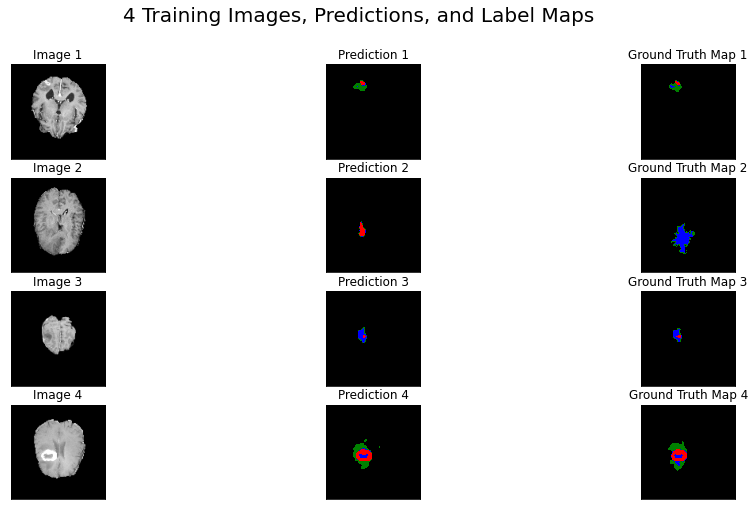

In [ ]:
# Randomly choose 4 images
test_images, test_labels = test_set.get_random_batch(4)
test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)

# Load the saved model
model_path = './saved_models/model_10000.pt'
model.load_state_dict(torch.load(model_path))

# Generate predictions
logits = model(test_images)
probs = F.softmax(logits, dim=1)
preds = torch.argmax(probs, dim=1)

# Create a 4x3 subplot grid
fig, axs = plt.subplots(4, 3, figsize=(16, 8))

for i in range(4):
  # Convert to the right format for printing
  image_np = test_images[i].cpu().numpy()
  pred_np = preds[i].cpu().numpy()
  label_np = test_labels[i].cpu().numpy()
  image_np = image_np.squeeze()

  # Plot the image and its label map
  axs[i, 0].imshow(image_np, cmap=cmap_gray)
  axs[i, 0].set_title(f'Image {i+1}')
  axs[i, 1].imshow(pred_np, cmap=cmap_label)
  axs[i, 1].set_title(f'Prediction {i+1}')
  axs[i, 2].imshow(label_np, cmap=cmap_label)
  axs[i, 2].set_title(f'Ground Truth Map {i+1}')

  # Remove the ticks from the plots
  axs[i, 0].set_xticks([])
  axs[i, 0].set_yticks([])
  axs[i, 1].set_xticks([])
  axs[i, 1].set_yticks([])
  axs[i, 2].set_xticks([])
  axs[i, 2].set_yticks([])

# Add a title to the figure
fig.suptitle('4 Training Images, Predictions, and Label Maps', fontsize=20)

# Show the plot
plt.show()

## 6. Discussion.

The testing of the model, performance metrics, and the visualisation exercise for predictions based on 4 random test images prove to us that this neural network architecture and model are effective for generating predictions very close to the truth labels, with minimal loss. However, medical images require higher level of precision than natural images might.

There is room for improvement in this design. Most foundational way of optimising the model is to tune the hyperparameters, including learning rate, weight decay, batch size, and optimizer. To increase the diversity of the model and improve its generalisation ability, some data augmentation techniques could be used, such as scaling, rotation, or flipping, which is particularly important in the biomedical sector due to the limitations on the size of available datasets. In case of rare diseases, labelled data supply is frequently very small and augmentation techniques can help increase that dataset. This has to be carried out with caution, however, to avoid overfitting.

In this particular code, max pooling was not explicitly implemented in the contractive path. It has been included in the original model as per Ronneberger et al. (2015) to downsample the feature maps and increase the receptive field, while reducing the number of parameters and improving the computational efficiency of the model. Instead, the model is using Conv2d functions with stride=2, which is an alternative that slightly reduces the memory usage of the network. However, a layer like this is slower than a layer with stride=1.

Additionally, dropout regularisation is a technique that could be beneficial in biomedical image segmentation like this one. By randomly dropping out some neurons during training, it forces the remaining neurons to learn more robust features that are useful for making accurate predictions on new data, which could result in better generalisation performance and improved accuracy on test data. It could improve the efficiency of the model, leading to faster training times and lower memory requirements, which could be important in a real clinic setting, as well as prevent the model from solely relying on any single neuron. Other regularisation techniques, such as L1 or L2, could also improve the model.

The model did implement batch normalisation, which helps improve performance and stability of a neural network. Particular benefits of this technique include improved training speed and model generalisation, such that overfitting can be reduced.

Lastly, experimentation with deeper structures could be beneficial to improve the model's performance, including another convolutional layer in the contractive path of the model, but also exploration of deeper network architectures, such as U-Net++. As per Zhou et al. (2018), if the feature maps from the decoder and encoder were semantically similar, the network would face a smaller problem in learning. In U-Net++, decoder and encoder are connected with multiple nested convolutional blocks. That way prior to concatenation, the feature maps of the decoder and encoder are becoming closer semantically.

[1] Olaf Ronneberger et al. U-Net: Convolutional networks for biomedical image segmentation. MICCAI, 2015. </br>
[2] Zongwei Zhou et al. UNet++: A Nested U-Net Architecture for Medical Image Segmentation. DLMIA, 2018.
